In [305]:
import torch
import matplotlib.pyplot as plt

In [265]:
%run 'operator.py'

In [294]:
def qboot(H, steps=1, tau=0.1, eps=0.1):
    rho = identity(H)
    M = identity(H)
    out = []
    for _ in range(steps):
        rho = rho - tau * (H - M).traceless()
        prj = identity(rho) - eps * rho
        M = prj @ M @ prj
        m = (M @ rho).trace.real
        if m < 0:
            M1 = M.traceless()
            rho = rho - m * M1 /(M1 @ M1).trace
        out.append((rho, M))
    return out

### Example 1: Single-Qubit Problem

Create a single-qubit Hamiltonian and bootstrap for 20 steps, return the density matrix in the last iteration.

In [297]:
H = - pauli('Z')
qboot(H, 20)[-1][0]

I +1 Z0

In [298]:
H = - pauli('X') - pauli('Z')
qboot(H, 20)[-1][0]

I +0.707 X0 +0.707 Z0

In [299]:
H = - pauli('X') - pauli('Y') - pauli('Z')
qboot(H, 20)[-1][0]

I +0.578 X0 +0.578 Y0 +0.578 Z0

### Example 2: Two-Site Hubbard Model

Define electron creation/annihilation and number operators.

In [300]:
def c(i,s):
    return (maj(4*i+2*s) + 1j * maj(4*i+2*s+1))/2
def cd(i,s):
    return (maj(4*i+2*s) - 1j * maj(4*i+2*s+1))/2
def n(i,s):
    return cd(i,s) @ c(i,s)

Construct the Hamiltonian of a two-site Hubbard model.

In [301]:
H = sum(cd(0,s) @ c(1,s)+cd(1,s) @ c(0,s) for s in [0,1]) \
    + sum(n(i,0) @ n(i,1) for i in [0,1])
H

0.5 I +0.25i χ6 χ7 +0.25i χ4 χ5 -0.25 χ4 χ5 χ6 χ7 -0.5i χ3 χ6 +0.5i χ2 χ7 +0.25i χ2 χ3 -0.5i χ1 χ4 +0.5i χ0 χ5 +0.25i χ0 χ1 -0.25 χ0 χ1 χ2 χ3

Quantum bootstrap 1000 steps.

In [311]:
out = qboot(H, 1000, tau=0.5, eps=0.1)

Energy expectation value $\mathrm{Tr} H \rho$.

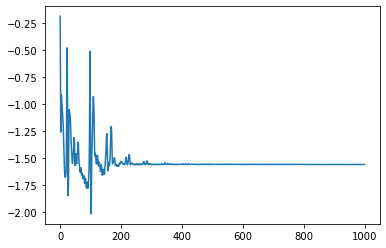

In [312]:
plt.plot(torch.stack([(H @ rho).trace.real for rho, M in out]))

The final energy expectation value is (ground truth: 1.56155)

In [322]:
(H @ out[-1][0]).trace.real.item()

-1.561978816986084

Positivity of density matrix $\mathrm{Tr}M \rho$.

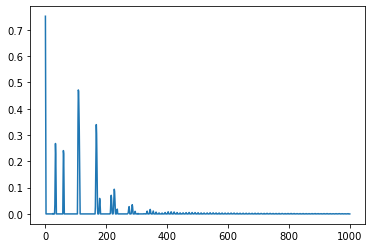

In [313]:
plt.plot(torch.stack([(M @ rho).trace.real for rho, M in out]))

Norm of positivity probe $\mathrm{Tr} M=\mathrm{Tr}O^\dagger O$.

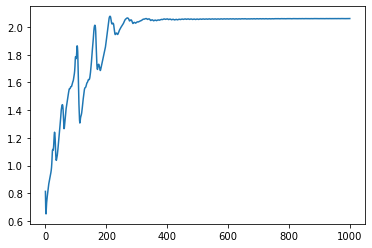

In [317]:
plt.plot([M.trace.real for rho, M in out])